<a href="https://colab.research.google.com/github/sultanm1/Decision-Trees-and-Nearest-Neighbours/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/'] 
### ========== TODO : END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        rows = y.shape[0]
        zero = 0
        one = 0
        for i in range(0, rows):
          if(y[i] == 0):
            zero = zero + 1
          else:
            one = one + 1
        # print("Results for zero and one", zero/rows, one/rows)

        self.probabilities_ = {0: zero/rows, 1: one/rows}

        ### ========== TODO : END ========== ###

        return self


    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n = X.shape[0]
        y = np.random.choice((0,1), (n,), p=(self.probabilities_[0], self.probabilities_[1]))
        
        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    strat = StratifiedShuffleSplit(n_splits = ntrials, test_size = test_size, train_size=1-test_size, random_state=0)
    strat.get_n_splits(X, y)

    train_scores = []
    test_scores = []
    f1 = []

    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        pred2 = clf.predict(X_train)
        test_scores.append(metrics.accuracy_score(y_test, pred, normalize=True))
        train_scores.append(metrics.accuracy_score(y_train, pred2, normalize=True))
        f1.append(metrics.f1_score(y_train, pred2, average='micro'))


    train_error = 1 - np.mean(train_scores)
    test_error = 1 - np.mean(test_scores)
    f1_score = 1 - np.mean(f1)
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- KNN N = 3, training error: 0.114
	-- KNN N = 5, training error: 0.129
	-- KNN N = 7, training error: 0.152
Investigating various classifiers...
Training Error for MajorityVoteClassifier is 0.240  while Test Error for MajorityVoteClassifier is 0.240
Training Error for RandomClassifier is 0.375  while Test Error for RandomClassifier is 0.382
Training Error for DecisionTreeClassifier 0.000  while Test Error for DecisionTreeClassifier is 0.207
Training Error for KNeighborsClassifier is 0.133  while Test Error for KNeighborsClassifier is 0.209
Finding the best k...
[0.2350000000000001, 0.21799999999999997, 0.20500000000000007, 0.21200000000000008, 0.20400000000000007, 0.19000000000000006, 0.19100000000000017, 0.19000000000000006, 0.18699999999999994, 0.187999999

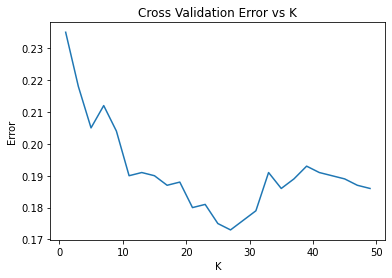

Investigating depths...


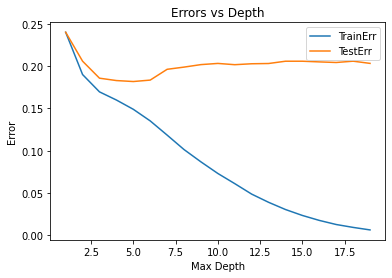

here


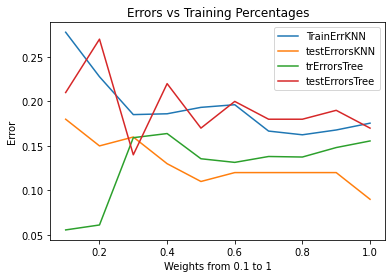

Done


In [ ]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/adult_subsample.csv"
    #DONE
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)
    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    #plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(X)
    
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(scaled, y)                  # fit training data using the classifier
    y_pred = clf.predict(scaled)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    #Unified fitting/predicting across the board
    clf = RandomClassifier()
    clf.fit(scaled,y)
    y_pred = clf.predict(scaled)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion = "entropy")
    clf.fit(scaled,y)
    y_pred = clf.predict(scaled)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    #This answer does make sense to some degree, given the fact we have unlimited max depth and 
    #no other parameters other than entropy. I'm sure that if we test it out it'll overfit
    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(scaled,y)
    y_pred = clf.predict(scaled)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- KNN N = 3, training error: %.3f' % train_error)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(scaled,y)
    y_pred = clf.predict(scaled)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- KNN N = 5, training error: %.3f' % train_error)

    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(scaled,y)
    y_pred = clf.predict(scaled)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- KNN N = 7, training error: %.3f' % train_error)
    #Training Error with KNN = 3 --> 0.153, KNN=5 --> 0.195, KNN=7 --> 0.213
    
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    clf = MajorityVoteClassifier()
    tr, test, f1 = error(clf,scaled,y)
    print("Training Error for MajorityVoteClassifier is %.3f" % tr, " while Test Error for MajorityVoteClassifier is %.3f" % test) 

    clf = RandomClassifier()
    tr, test, f1 = error(clf,scaled,y)
    print("Training Error for RandomClassifier is %.3f" % tr, " while Test Error for RandomClassifier is %.3f" % test) 

    clf = DecisionTreeClassifier(criterion = "entropy")
    tr, test, f1 = error(clf,scaled,y)
    print("Training Error for DecisionTreeClassifier %.3f" % tr, " while Test Error for DecisionTreeClassifier is %.3f" % test) 

    clf = KNeighborsClassifier(n_neighbors=5)
    tr, test, f1 = error(clf,scaled,y)
    print("Training Error for KNeighborsClassifier is %.3f" % tr, " while Test Error for KNeighborsClassifier is %.3f" % test) 
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    error1 = []
    xrange = []
    for i in range(1, 50, 2):
      clf = KNeighborsClassifier(n_neighbors=i)
      clf.fit(scaled,y)
      error1.append(1 - cross_val_score(clf, scaled, y, cv = 10).mean())
      xrange.append(i)

    print(error1)
    plt.plot(xrange, error1)
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title('Cross Validation Error vs K')
    plt.show()


    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    trainErrorDecision = []
    testErrorDecision = []
    rng = []
    for i in range(1,20):
      clf = DecisionTreeClassifier(criterion = "entropy", max_depth=i)
      tr, test, f1 = error(clf,scaled,y)
      trainErrorDecision.append(tr)
      testErrorDecision.append(test)
      rng.append(i)

    plt.plot(rng, trainErrorDecision, label = "TrainErr")
    plt.plot(rng, testErrorDecision, label = "TestErr")
    plt.xlabel('Max Depth')
    plt.ylabel('Error')
    plt.title('Errors vs Depth')
    plt.legend()
    plt.show()



    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size = 0.1, random_state=0)
    weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    trErrorsKNN = []
    testErrorsKNN = []
    trErrorsTree = []
    testErrorsTree = []

    for i in range(0, len(weights)):
      weight = weights[i]
      if(weight == 1):
        print("here")
        clf = KNeighborsClassifier(n_neighbors=26)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_train)
        train_error = 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)
        trErrorsKNN.append(train_error)
        y_pred2 = clf.predict(X_test)
        test_error = 1 - metrics.accuracy_score(y_test, y_pred2, normalize=True)
        testErrorsKNN.append(test_error)

        clf = DecisionTreeClassifier(criterion = "entropy", max_depth=5)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_train)
        train_error = 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)
        trErrorsTree.append(train_error)
        y_pred2 = clf.predict(X_test)
        test_error = 1 - metrics.accuracy_score(y_test, y_pred2, normalize=True)
        testErrorsTree.append(test_error)
      else:
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, train_size = weight, random_state=0)

        clf = KNeighborsClassifier(n_neighbors=26)
        clf.fit(X_train2,y_train2)
        y_pred = clf.predict(X_train2)
        train_error = 1 - metrics.accuracy_score(y_train2, y_pred, normalize=True)
        trErrorsKNN.append(train_error)
        y_pred2 = clf.predict(X_test)
        test_error = 1 - metrics.accuracy_score(y_test, y_pred2, normalize=True)
        testErrorsKNN.append(test_error)

        clf = DecisionTreeClassifier(criterion = "entropy", max_depth=5)
        clf.fit(X_train2,y_train2)
        y_pred = clf.predict(X_train2)
        train_error = 1 - metrics.accuracy_score(y_train2, y_pred, normalize=True)
        trErrorsTree.append(train_error)
        y_pred2 = clf.predict(X_test)
        test_error = 1 - metrics.accuracy_score(y_test, y_pred2, normalize=True)
        testErrorsTree.append(test_error)


    plt.plot(weights, trErrorsKNN, label = "TrainErrKNN")
    plt.plot(weights, testErrorsKNN, label = "testErrorsKNN")
    plt.plot(weights, trErrorsTree, label = "trErrorsTree")
    plt.plot(weights, testErrorsTree, label = "testErrorsTree")
    plt.xlabel('Weights from 0.1 to 1')
    plt.ylabel('Error')
    plt.title('Errors vs Training Percentages')
    plt.legend()
    plt.show()





    
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
